## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from itertools import product
import missingno as msno
from sklearn.metrics import mean_squared_log_error
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
torch.set_num_threads(8)

'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
C:\Users\Igor\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Igor\AppData\Local\Programs\Python\Python310\lib\site-packages\lightautoml\text\tokenizer.py:21: UserWarning: 'nltk' - package isn't installed
  warnings.warn("'nltk' - package isn't installed")
C:\Users\Igor\AppData\Local\Programs\Python\Python310\lib\site-packages\lightautoml\ml_algo\dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


## Загрузка и настройка

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [5]:
#функция для подсчёта rmsle
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [6]:
#мало значений
train = train.drop(train[train.dri_score=='Missing disease status'].index)
#sex_match слишком важная фича, поэтому удаляем записи
#с пропусками в этой фиче
train = train.drop(train[train.sex_match.isna()].index)

## EDA

In [7]:
#функция для нахождения пропусков по вероятностям
#Input: датафрейм, фича для восстановления, группа функции, 
#по которым будет произведен подсчёт вероятностей
def fill_missing_values(df, feature, group_cols):
    # Рассчитываем вероятности значений feature в группах
    probs = (df.dropna(subset=[feature])
               .groupby(group_cols)[feature]
               .value_counts(normalize=True)
               .unstack()
               .fillna(0))  # Заменяем NaN на 0
    
    # Функция для заполнения пропусков
    def impute(row):
        if pd.isna(row[feature]):
            group_key = tuple(row[col] for col in group_cols)
            if group_key in probs.index:
                p_values = probs.loc[group_key].values
                if np.sum(p_values) > 0:  # Проверяем, что вероятности ненулевые
                    p_values = p_values / np.sum(p_values)  # Нормируем до 1
                    return np.random.choice(probs.columns, p=p_values)
        return row[feature]

    df[feature] = df.apply(impute, axis=1)
    return df

In [8]:
def fix_hla(train: pd.DataFrame()):
    #В данных присутствуют ошибки, лучше пересчитать кумалятивные фичи
    #nmdp_6_restore
    df = train.copy()
    df['hla_nmdp_6'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) + df['hla_match_drb1_high'].fillna(0)
   
    #hla_res_6_restore
    df['hla_low_res_6'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) + df['hla_match_drb1_low'].fillna(0)
    df['hla_high_res_6'] = df['hla_match_a_high'].fillna(0) + df['hla_match_b_high'].fillna(0) + df['hla_match_drb1_high'].fillna(0)
    #hla_res_8_restore
    df['hla_low_res_8'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) \
    + df['hla_match_drb1_low'].fillna(0) + df['hla_match_c_low'].fillna(0)
    df['hla_high_res_8'] = df['hla_match_a_high'].fillna(0) + df['hla_match_b_high'].fillna(0) \
    + df['hla_match_drb1_high'].fillna(0) + df['hla_match_c_high'].fillna(0)
    #hla_res_10_restore
    df['hla_low_res_10'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) \
    + df['hla_match_c_low'].fillna(0) + df['hla_match_dqb1_low'].fillna(0) + df['hla_match_drb1_low'].fillna(0)
    df['hla_high_res_10'] = df['hla_match_a_high'].fillna(0) + df['hla_match_b_high'].fillna(0) \
    + df['hla_match_c_high'].fillna(0) + df['hla_match_dqb1_high'].fillna(0) + df['hla_match_drb1_high'].fillna(0)
    return df

In [9]:
def fe(df_read):
    #разбиваю фичу на 4 составляющие
    #зачем - повысить точность модели
    tbi_status_category = ['tbi_given', 'tbi_dose', 'tbi_fractionation', 'tbi_cy']
    tbi_status_map = {
        'No TBI':                           ( 0,  0,  0,  0),
        'TBI +- Other, >cGy':               ( 1,  3,  3,  0),
        'TBI +- Other, <=cGy':              ( 1,  1,  3,  0),
        'TBI +- Other, unknown dose':       ( 1,  4,  3,  0),
        'TBI +- Other, -cGy, fractionated': ( 1,  2,  1,  0),
        'TBI +- Other, -cGy, single':       ( 1,  2,  2,  0),
        'TBI +- Other, -cGy, unknown dose': ( 1,  2,  3,  0),
        'TBI + Cy +- Other':                ( 1,  4,  3,  1) }
    
    for i, newcol in enumerate(tbi_status_category):
        newmap = {key:tup[i] for key,tup in tbi_status_map.items()}
        df_read[newcol] = df_read['tbi_status'].map(newmap)
        df_read[newcol] = df_read[newcol].astype('float32').fillna(-1).astype('int32').astype('category')

    #возрастные фичи и пол
    df_read['age_at_hct'] = (df_read['age_at_hct'].fillna(df_read.age_at_hct.median())).astype('int')
    df_read['donor_age'] = (df_read['donor_age'].fillna(df_read.donor_age.median())).astype('int')

    #поколение по возрастам
    #зачем - предположение, что разные поколения лучше переносят
    df_read['pct_generation'] = pd.cut(
        df_read['age_at_hct'],
        bins=range(0, 101, 10),  
        labels=[f"{i}-{i+9}" for i in range(0, 100, 10)],  # Названия поколений
        right=False  
        )
    df_read['donor_generation'] = pd.cut(
        df_read['donor_age'],
        bins=range(0, 101, 10), 
        labels=[f"{i}-{i+9}" for i in range(0, 100, 10)],  # Названия поколений
        right=False 
        )
    df_read[['donor_sex', 'pacient_sex']] = df_read['sex_match'].str.split('-', expand=True)
    
    #добавляем средний возраст смерти + правим на пол
    mean_death_age_mapping = {
        'American Indian or Alaska Native': 65.2,
        'Native Hawaiian or other Pacific Islander': 65.2,
        'White': 76.1,
        'Black or African-American': 70.8,
        'Asian': 83.5,
        'More than one race': 71.56 #среднее по остальным
    }
    
    df_read['mean_death_age'] = df_read['race_group'].map(mean_death_age_mapping)
    df_read['mean_death_age'] = np.where(
    df_read['pacient_sex'] == 'M', df_read['mean_death_age'] - 2,
        np.where(df_read['pacient_sex'] == 'F', df_read['mean_death_age'] + 5.8, df_read['mean_death_age'])
    )


    #добавляем год рождения и пенсию
    df_read['birth_year'] = df_read['year_hct'].astype('int') - df_read['age_at_hct'].astype('int')
    df_read['pension'] = np.where(
        df_read['birth_year'] < 1954, 
        65, 
        np.minimum(65 + (df_read['birth_year'] - 1954), 67)
    )


    #больше ли текущий возраст среднего возраста смерти
    df_read['bigger_death_age'] = df_read.age_at_hct > df_read.mean_death_age

    # Разделяем значения на два отдельных аллеля
    df_read[['allele_1', 'allele_2']] = df_read['cmv_status'].str.split('/', expand=True)
    
    df_read = df_read.drop(['cmv_status'], axis=1)
    
    return df_read

In [10]:
train = fe(train)
train = train.drop(['tbi_status'], axis=1)
test = fe(test)
test = test.drop(['tbi_status'], axis=1)

## Восстановление фичей

In [11]:
#восстанавливаем фичи по совместимости исходя из вероятностей
hla_columns = [col for col in train.columns if 'hla' in col ]
group_columns = ['race_group', 'sex_match', 'pct_generation', 'donor_generation']
for i in hla_columns:
    train = fill_missing_values(train, i, group_columns)
    test = fill_missing_values(test, i, group_columns)

In [12]:
#выбираем категориальные фичи, по которым будем делать восстановление
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
#не трогаем hla колонки, так как они немного за другое отвечают
categorical_columns = [
    col for col in categorical_columns 
    if col not in ['race_group', 'pacient_sex', 'pacient_generation'] and not col.startswith('hla_')
]
group_columns = ['race_group', 'pacient_sex', 'pct_generation']
for i in categorical_columns:
    train = fill_missing_values(train, i, group_columns)
    test = fill_missing_values(test, i, group_columns)

In [13]:
## Обновлённая версия с большим количеством фичей
#лучший скор 'race_group', 'pacient_sex', 'pct_generation'  
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], event_observed=df[event_col])
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    return survival_probabilities


def update_target_with_survival_probabilities(df, time_col='efs_time', event_col='efs', selected_features=['race_group']):
    
    grouping_cols = selected_features
    unique_groups = df[grouping_cols].drop_duplicates()
    
    survival_probs_dict = {}
    for _, group in unique_groups.iterrows():
        condition = (df[grouping_cols] == group).all(axis=1)
        group_df = df[condition]
        survival_probs_dict[tuple(group)] = transform_survival_probability(group_df, time_col, event_col)
    
    for group, probs in survival_probs_dict.items():
        condition = (df[grouping_cols] == group).all(axis=1)
        df.loc[condition, 'target'] = probs
    
    df.loc[df[event_col] == 0, 'target'] -= 0.15
    
    return df

In [14]:
train = update_target_with_survival_probabilities(train, 'efs_time', 'efs', ['race_group', 'pacient_sex', 'pct_generation'])

In [15]:
def train_model(train, selected_features):
    df = train.copy()
    df = prepare_train(train, selected_features)
    numerical_features = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col not in ['ID', 'efs', 'efs_time', 'target']]
    tr_data, te_data = train_test_split(df, test_size=0.25, random_state=42)
    task = Task('reg', loss='mse', metric='mse')
    roles = {
        'target' : 'target'
    }
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Дополнительно: если числовые признаки имеют низкую кардинальность
    low_cardinality_features = [
        col for col in df.select_dtypes(include=['int64', 'float64']).columns if df[col].nunique() <= 10
        and 'hla_' not in col
    ]
    
    # Итоговые категориальные фичи
    categorical_features += low_cardinality_features
    
    automl = TabularAutoML(task=task,
                          timeout=600,
                          cpu_limit=16,
                          reader_params={
                              'use_algos': ['lgb', 'cb'],
                              'force_input_features': categorical_features,
                              'n_jobs' : 8,
                              'cv' : 10,
                              'random_state': 13,
                              'verbose' : 1
                          })
    
    oof_pred = automl.fit_predict(tr_data, roles=roles, verbose=1)
    
    y_true = te_data.target  # Истинные значения (целевой столбец)
    y_pred = automl.predict(te_data).data[:, 0]  # Предсказания
    
    # Вычисляем MSE
    mse = mean_squared_error(y_true, y_pred)
    print(f'Набор фичей {selected_features} MSE: {mse}')
    return mse

In [16]:
#После средней продолжительности жизни
#Набор фичей: ['sex_match', 'bigger_death_age', 'race_group'] - MSE: 0.0462235261236498
#Набор фичей: ['sex_match', 'bigger_death_age', 'pacient_sex', 'race_group'] - MSE: 0.04622400428541343
#Набор фичей: ['sex_match', 'race_group'] - MSE: 0.046275202332456175




#После выхода на пенсию
#Набор фичей: ['pacient_sex'] - MSE: 0.04630323800199562
#Набор фичей: ['bigger_death_age', 'race_group', 'pacient_sex'] - MSE: 0.046307475545060345
#Набор фичей: ['race_group', 'sex_match'] - MSE: 0.04634786033791707

In [17]:
#новая фича
df.groupby(['dri_score', 'cyto_score', 'cyto_score_detail'], as_index=False)\
    .agg({'target':['mean', 'count']})\
    .sort_values(by=[('target', 'count'), ('target', 'mean')], ascending=[False, False])\
    .head(15)

NameError: name 'df' is not defined

In [18]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [19]:
RMV = ["ID","efs","efs_time","target"]
FEATURES = [c for c in train.columns if not c in RMV]

In [20]:
train[categorical_columns] = train[categorical_columns].astype(str).fillna("missing")
test[categorical_columns] = test[categorical_columns].astype(str).fillna("missing")
print(train[categorical_columns].isna().sum())
print(test[categorical_columns].isna().sum())

dri_score                 0
psych_disturb             0
cyto_score                0
diabetes                  0
arrhythmia                0
graft_type                0
vent_hist                 0
renal_issue               0
pulm_severe               0
prim_disease_hct          0
tce_imm_match             0
rituximab                 0
prod_type                 0
cyto_score_detail         0
conditioning_intensity    0
ethnicity                 0
obesity                   0
mrd_hct                   0
in_vivo_tcd               0
tce_match                 0
hepatic_severe            0
prior_tumor               0
peptic_ulcer              0
gvhd_proph                0
rheum_issue               0
sex_match                 0
hepatic_mild              0
tce_div_match             0
donor_related             0
melphalan_dose            0
cardiac                   0
pulm_moderate             0
donor_sex                 0
allele_1                  0
allele_2                  0
dtype: int64
dri_sco

In [21]:
#выбираем категориальные фичи, по которым будем делать восстановление
categorical_columns = train.select_dtypes(include=['object', 'category']).columns.tolist()
#не трогаем hla колонки, так как они немного за другое отвечают
categorical_columns = [
    col for col in categorical_columns 
    if not col.startswith('hla_')
]

In [24]:
%%time
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb

FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.iloc[train_index][FEATURES].copy()
    y_train = train.iloc[train_index]["target"]
    x_valid = train.iloc[test_index][FEATURES].copy()
    y_valid = train.iloc[test_index]["target"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",  
        learning_rate=0.1,    
        grow_policy='Lossguide',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=categorical_columns,
              verbose=250)

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.2403360	test: 0.2392867	best: 0.2392867 (0)	total: 12ms	remaining: 12s
250:	learn: 0.2009253	test: 0.2215634	best: 0.2215634 (250)	total: 2.05s	remaining: 6.11s
500:	learn: 0.1887007	test: 0.2221425	best: 0.2213779 (304)	total: 4.13s	remaining: 4.11s
750:	learn: 0.1781557	test: 0.2229296	best: 0.2213779 (304)	total: 6.27s	remaining: 2.08s
999:	learn: 0.1690508	test: 0.2239556	best: 0.2213779 (304)	total: 8.49s	remaining: 0us
bestTest = 0.2213779407
bestIteration = 304
Shrink model to first 305 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.2398109	test: 0.2435620	best: 0.2435620 (0)	total: 9.59ms	remaining: 9.58s
250:	learn: 0.2001644	test: 0.2232252	best: 0.2230014 (171)	total: 2.16s	remaining: 6.46s
500:	learn: 0.1877707	test: 0.2233471	best: 0.2227877 (306)	total: 4.26s	remaining: 4.24s
750:	learn: 0.1774789	test: 0.2232835	best: 0.2227877 (306)	total: 6.32s	remaining: 

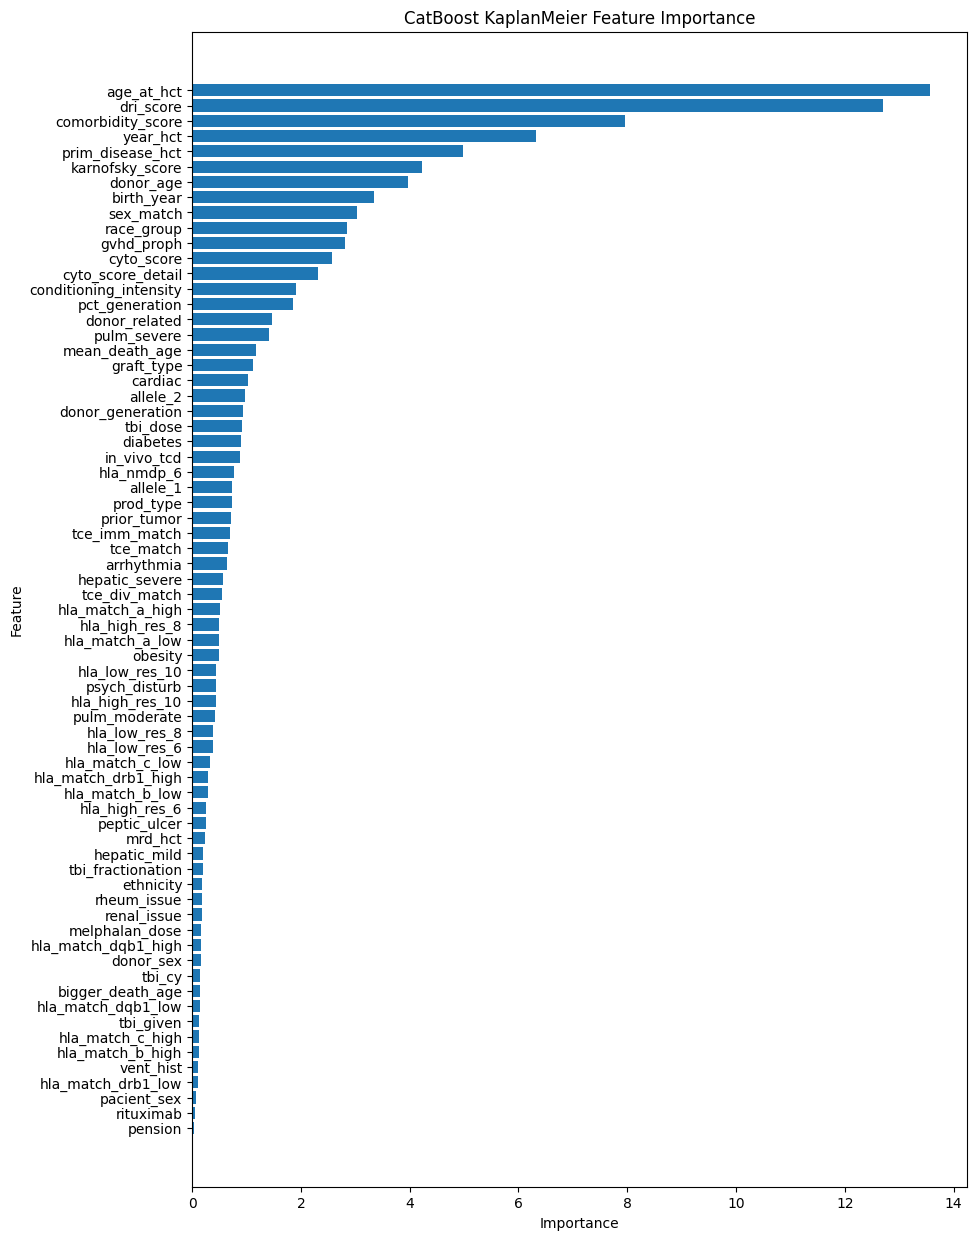

In [27]:
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [28]:
from scipy.stats import rankdata 

In [29]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = rankdata(pred_xgb) + rankdata(pred_cat) + rankdata(pred_lgb)\
                     + rankdata(pred_xgb_cox) + rankdata(pred_cat_cox)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv'